In [1]:
import matplotlib.pyplot as plt

from Code_for_the_files.Kalman_General import *
from scipy.io import loadmat,savemat
import pickle

In [2]:
c1 = 10
c2 = 10
c3 = 0.5
c4 = 0
c5 = 0.5
k1 = 1000
k2 = 1
k3 = 1000
k4 = 0.04


Omega = 10

c1_tilde = c1 / Omega
c2_tilde = c2 / Omega
c3_tilde = c3 * Omega
c4_tilde = c4 / Omega
c5_tilde = c5
k1_tilde = k1 / Omega
k2_tilde = k2 / Omega
k3_tilde = k3 / Omega
k4_tilde = k4

T = 1

z10 = 0
z20 = 0
x10 = 0
initial_conditions = {'z_1': z10, 'z_2': z20, 'x_1': x10}

In [3]:
# The network structure
species_names = ['Z_1', 'Z_2', 'X_1']
#species names and propensities variables need to be consistent for the following code to work
stoichiometric_matrix = np.array([[1, 0, -1, 0, 0], [0, 1, -1, 0, 0], [0, 0, 0, 1, -1]])
parameters_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'k1', 'k2', 'k3', 'k4']
parameter_values = {'c1': c1, 'c2': c2, 'c3': c3, 'c4': c4, 'c5': c5, 'k1': k1, 'k2': k2, 'k3': k3, 'k4': k4}
reaction_names = ['z1 prod.', 'z2 prod.', 'z1,z2 deg.', 'prot prod.', 'prot deg.']
propensities = [
    lambda c1: c1,
    lambda c2: c2,
    lambda c3, Z_1, Z_2: c3*Z_1*Z_2,
    lambda c4, k1, k2, k3, k4, Z_1, Z_2: c4+(k3*(Z_1/k1))/(k4+(Z_1/k1)+(Z_2/k2)),
    lambda c5, X_1: c5*X_1
]

observable_species = ['X_1']
range_of_species = pd.DataFrame({'min': [0, 0], 'max': [500, 500]}, index=['Z_1', 'Z_2'])

range_of_parameters = pd.DataFrame([[c1, c1], [c2, c2], [c3, c3], [c4, c4], [c5, c5], [k1, k1], [k2, k2], [k3, k3], [k4, k4]], index=parameters_names, columns=['min', 'max'])
discretization_size_parameters = pd.DataFrame([1, 1, 1, 1, 1, 1, 1, 1, 1], index=parameters_names)

CF_not_scaled = CRNForContinuousTimeFiltering(stoichiometric_matrix=stoichiometric_matrix,
                                              species_names=species_names,
                                              parameters_names=parameters_names,
                                              reaction_names=reaction_names,
                                              propensities=propensities,
                                              observable_species=observable_species,
                                              range_of_species=range_of_species,
                                              range_of_parameters=range_of_parameters,
                                              discretization_size_parameters=discretization_size_parameters)

In [4]:
hidden_species = [species for species in species_names if species not in observable_species]

In [5]:
# Loading data from a .pkl file
with open('data_for_python.pkl', 'rb') as pkl_file:
    pkl_data_loaded = pickle.load(pkl_file)
# Accessing the data
time_list_1 = pkl_data_loaded['time_of_observations']
observed_state_sequence = pkl_data_loaded['state_sequence']
observed_data = pkl_data_loaded['observed_data']
time_list = pkl_data_loaded['time_list']
hidden_trajectories = pkl_data_loaded['hidden_trajectories']
true_trajectories = pkl_data_loaded['true_trajectories']
print("Data loaded from 'data_for_python.pkl'")

Data loaded from 'data_for_python.pkl'


In [6]:
observed_data['X_1']=observed_data['x1']
del observed_data['x1']
observed_data

{'X_1': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 10.,
        11., 12., 13., 14., 13., 14., 15., 14., 13., 14., 13., 14., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 20., 19., 18., 18.])}

In [10]:
# Observations
observations = [
    {'time': time_list_1, 'state': np.array([observed_data[species] for species in observable_species]).T}
]

N = 1001
# Running Kalman Filter
rho = 0.013
initial_conditions_1 = {
    'hat_z_0': [z10, z20, x10],
    'R_0': np.zeros((3, 3)),
    'species_values': {'Z_1': z10, 'Z_2': z20, 'X_1': x10}
}

parameter_values_tilde = {'c1': c1_tilde, 'c2': c2_tilde, 'c3': c3_tilde, 'c4': c4_tilde, 'c5': c5_tilde, 'k1': k1_tilde, 'k2': k2_tilde, 'k3': k3_tilde, 'k4': k4_tilde}
#the observation function variables names need to be the same as the species names declared above
observation_func = lambda Z_1, Z_2, X_1: X_1

common_time_points, hat_z_t_trajectory, R_t_trajectory, bar_z_t_trajectory = kalman_filter(
    initial_conditions_1, observations, parameter_values_tilde, propensities, stoichiometric_matrix, observation_func, Omega, rho, N
)

# Running Extended Kalman Filter
initial_conditions_2 = {
    'hat_z_0': [z10, z20, x10],
    'R_0': np.eye(3) * 1e-6,
    'species_values': {'Z_1': z10, 'Z_2': z20, 'X_1': x10}
}
common_time_points_1, hat_z_t_trajectory_1, R_t_trajectory_1 = extended_kalman_filter(
    initial_conditions_2, observations, parameter_values_tilde, propensities, stoichiometric_matrix, observation_func, Omega, rho, N
)

In [11]:
# Load the results from MATLAB
ffsp_results = loadmat('FFSP_estimations_maybe_1.mat')
particle_results = loadmat('particle_estimations_maybe_1.mat')

# Extract FFSP and Particle Filter estimations
E_FSP = ffsp_results['E_FSP']
SD_FSP = ffsp_results['SD_FSP']
E_PF = particle_results['E_PF']
SD_PF = particle_results['SD_PF']

# Ensure that the extra species from Kalman and Extended Kalman are excluded
kalman_trajectory_trimmed = hat_z_t_trajectory[:len(hidden_species)]
kalman_R_trajectory_trimmed = R_t_trajectory[:, :len(hidden_species), :len(hidden_species)]
ekf_trajectory_trimmed = hat_z_t_trajectory_1[:len(hidden_species)]
ekf_R_trajectory_trimmed = R_t_trajectory_1[:, :len(hidden_species), :len(hidden_species)]

# Debugging: Print shapes of relevant variables
print(f"time_list shape: {time_list.shape}")
print(f"hidden_trajectories shape: {hidden_trajectories.shape}")
print(f"common_time_points shape: {common_time_points.shape}")

# Observable data from SSA
observed_trajectories = np.array([observed_data[species] for species in observable_species]).T

# Interpolate FFSP and Particle Filter estimations to common_time_points
interp_ffsp = interp1d(time_list_1, E_FSP, axis=0, fill_value="extrapolate")
interp_ffsp_sd = interp1d(time_list_1, SD_FSP, axis=0, fill_value="extrapolate")
interp_pf = interp1d(time_list_1, E_PF, axis=0, fill_value="extrapolate")
interp_pf_sd = interp1d(time_list_1, SD_PF, axis=0, fill_value="extrapolate")

E_FSP_interp = interp_ffsp(common_time_points)
SD_FSP_interp = interp_ffsp_sd(common_time_points)
E_PF_interp = interp_pf(common_time_points)
SD_PF_interp = interp_pf_sd(common_time_points)

# Prepare data for plotting
print(f"Final shapes - common_time_points: {common_time_points.shape}, observed_trajectories: {observed_trajectories.shape}")


time_list shape: (63,)
hidden_trajectories shape: (2, 63)
common_time_points shape: (1001,)
Final shapes - common_time_points: (1001,), observed_trajectories: (38, 1)


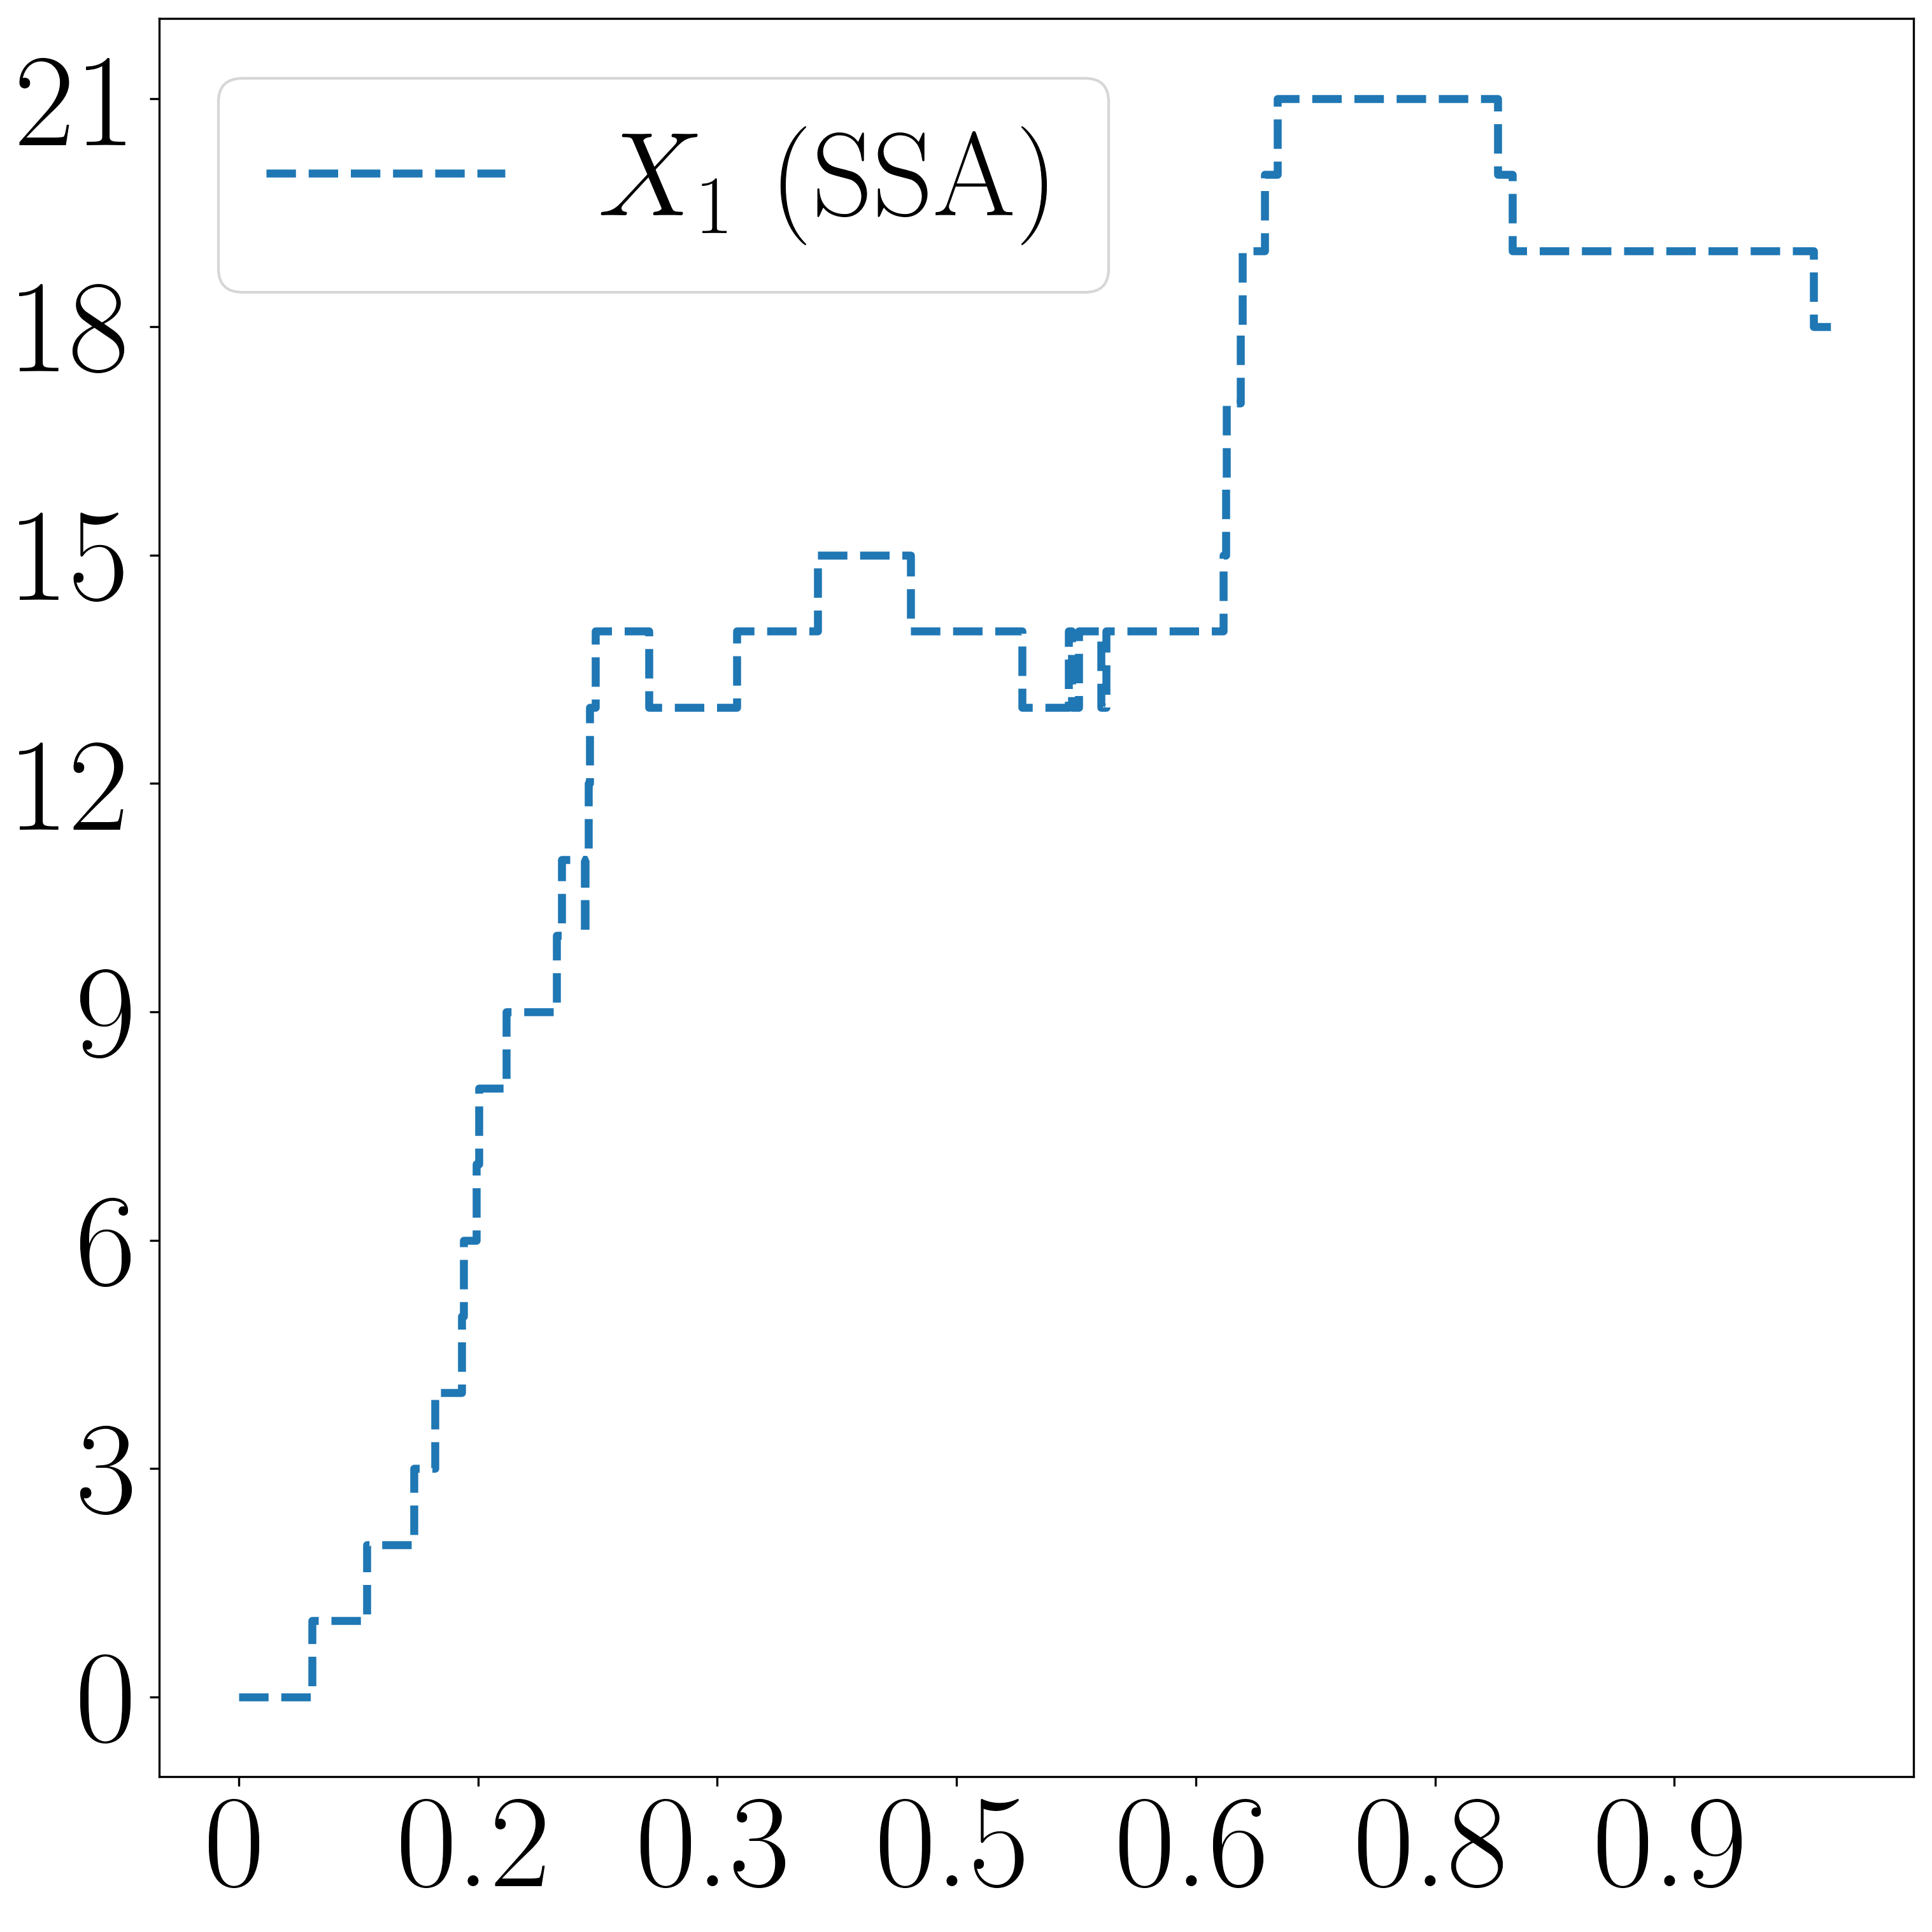

In [16]:
# Example usage
fig = plot_observation_trajectory(time_list_1, observed_trajectories, observable_species)
fig.savefig('Observation_Trajectory.pdf',dpi=300)

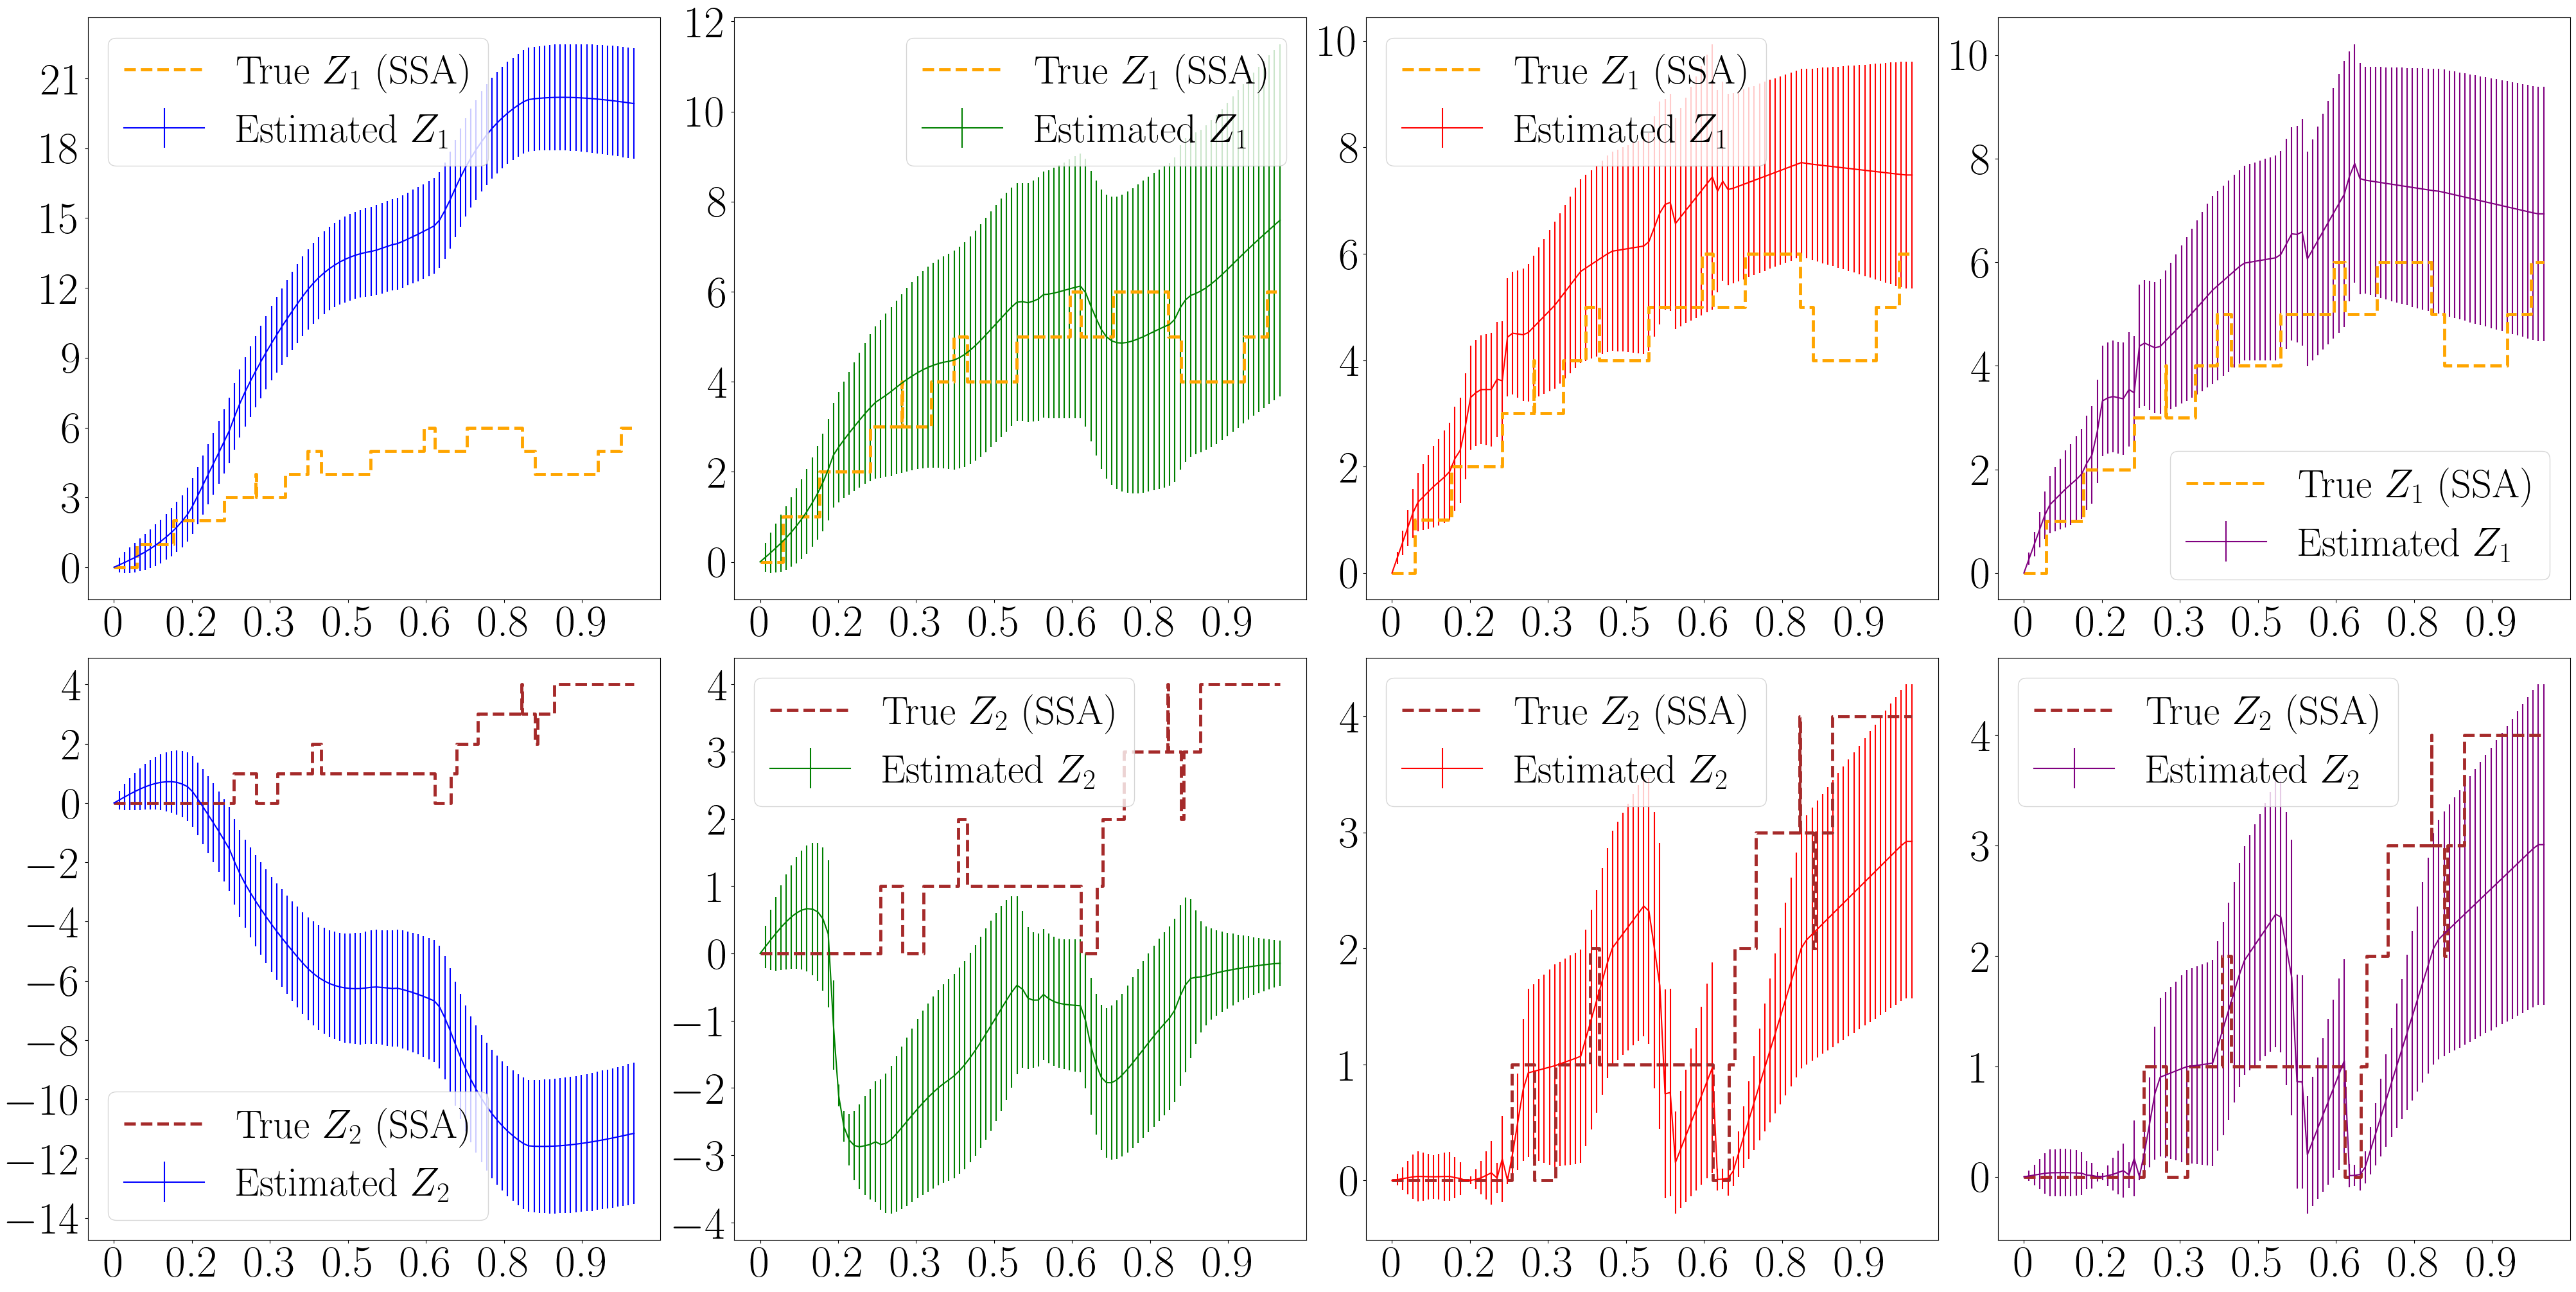

In [21]:
# Example of how to use the function with point_density parameter
fig_1 = plot_filters_results_total_no_labels(common_time_points, kalman_trajectory_trimmed, kalman_R_trajectory_trimmed, ekf_trajectory_trimmed, ekf_R_trajectory_trimmed, E_PF_interp, SD_PF_interp, E_FSP_interp, SD_FSP_interp, time_list, hidden_trajectories, observed_trajectories, time_list_1, hidden_species, point_density=0.1)


In [22]:
fig_1.savefig('Filters_rho_0013.pdf', dpi=300)

In [12]:
# Step 4: Saving Data for MATLAB
mat_data = {
    'initial_conditions': initial_conditions,
    'parameter_values': parameter_values,
    'time_of_observations': time_list_1,
    'state_sequence': observed_state_sequence,
    'observation_func': 'X_1',
    'time_list': time_list,
    'hidden_trajectories': hidden_trajectories,
    'common_time_points': common_time_points,
    'hat_z_t_trajectory': kalman_trajectory_trimmed,
    'R_t_trajectory': kalman_R_trajectory_trimmed,
    'hat_z_t_trajectory_1': ekf_trajectory_trimmed,
    'R_t_trajectory_1': ekf_R_trajectory_trimmed,
    'E_FSP_interp': E_FSP_interp,
    'SD_FSP_interp': SD_FSP_interp,
    'E_PF_interp': E_PF_interp,
    'SD_PF_interp': SD_PF_interp
}
savemat('data_for_matlab_with_filters_0013.mat', mat_data)